In [134]:
# urn and other imports
import unityneuro.render as urn
import numpy as np
import pandas as pd
# ibl imports
from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')
from brainbox.io.one import SpikeSortingLoader
import ibllib.atlas as atlas
CCFAtlas = atlas.AllenAtlas(25)
NeedlesAtlas = atlas.NeedlesAtlas(25)
MRITorontoAtlas = atlas.MRITorontoAtlas(25)
from brainwidemap import bwm_loading
import random
import matplotlib.pyplot as plt

In [2]:
ins = bwm_loading.bwm_query(one)

In [8]:
ins

,pid,eid,probe_name,session_number,date,subject,lab
0,47be9ae4-290f-46ab-b047-952bc3a1a509,56956777-dca5-468c-87cb-78150432cc57,probe01,1,2020-02-21,NYU-11,angelakilab
1,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,56956777-dca5-468c-87cb-78150432cc57,probe00,1,2020-02-21,NYU-11,angelakilab
2,1e176f17-d00f-49bb-87ff-26d237b525f1,a8a8af78-16de-4841-ab07-fde4b5281a03,probe00,1,2020-01-22,NYU-12,angelakilab
3,701026df-e170-4ca7-88aa-eb0b95ef6ba1,a8a8af78-16de-4841-ab07-fde4b5281a03,probe01,1,2020-01-22,NYU-12,angelakilab
4,6506252f-1141-4e11-8816-4db01b71dda0,032ffcdf-7692-40b3-b9ff-8def1fc18b2e,probe01,1,2020-01-23,NYU-12,angelakilab
...,...,...,...,...,...,...,...
459,81b1800e-f138-4337-abc9-bb0449b77852,993c7024-0abc-4028-ad30-d397ad55b084,probe00,1,2020-09-16,CSH_ZAD_029,zadorlab
460,5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e,fece187f-b47f-4870-a1d6-619afe942a7d,probe01,1,2020-09-17,CSH_ZAD_029,zadorlab
461,f7c93877-ec05-4091-a003-e69fae0f2fa8,fece187f-b47f-4870-a1d6-619afe942a7d,probe00,1,2020-09-17,CSH_ZAD_029,zadorlab
462,675952a4-e8b3-4e82-a179-cc970d5a8b01,c7bd79c9-c47e-4ea5-aea3-74dda991b48e,probe01,1,2020-09-19,CSH_ZAD_029,zadorlab


# Collect insertion data (planned/micro-manip/histology)

In [45]:
def vec_dist(coord0, coord1):
    return np.sqrt(np.sum(np.power([coord0[0]-coord1[0],coord0[1]-coord1[1],coord0[2]-coord1[2]],2)))
def vec_dist_apml(coord0, coord1):
    return np.sqrt(np.sum(np.power([coord0[0]-coord1[0],coord0[1]-coord1[1]],2)))

def getCoords(ins, coord_transform):
    entry_coords = coord_transform.xyz2ccf(ins.entry, mode='raise')
    tip_coords = coord_transform.xyz2ccf(ins.tip, mode='raise')
    angles = [ins.phi, ins.theta, ins.beta]
    depth = vec_dist(entry_coords, tip_coords)
    return (entry_coords, tip_coords, angles, depth)

def traj2coords(traj, coord_transform):
    insertion = atlas.Insertion.from_dict(traj)
    return getCoords(insertion, coord_transform)


In [4]:
prov_planned = 'planned'
prov_mm = 'Micro-manipulator'
prov_ephys = 'Ephys aligned histology track'

bwm_planned = one.alyx.rest('trajectories', 'list', provenance=prov_planned,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)
bwm_mm = one.alyx.rest('trajectories', 'list', provenance=prov_mm,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)
bwm_ephys = one.alyx.rest('trajectories', 'list', provenance=prov_ephys,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)

In [7]:
# re-organize data into a dictionary
data = {}
for i, row in ins.iterrows():
    data[row['pid']] = {}
    
for traj in bwm_planned:
    pid = traj['probe_insertion']
    
    if pid in data.keys():
        data[pid]['planned'] = traj
        
for traj in bwm_mm:
    pid = traj['probe_insertion']
    
    if pid in data.keys():
        data[pid]['micro-manip'] = traj
        
for traj in bwm_ephys:
    pid = traj['probe_insertion']
    
    if pid in data.keys():
        data[pid]['ephys'] = traj

In [79]:
traj_data = pd.DataFrame(columns=['pid','lab',
                                  'ml_e_p','ap_e_p','dv_e_p',
                                  'ml_t_p','ap_t_p','dv_t_p',
                                  'phi_p','theta_p','depth_p',
                                  'ml_e_m','ap_e_m','dv_e_m',
                                  'ml_t_m','ap_t_m','dv_t_m',
                                  'phi_m','theta_m','depth_m',
                                  'ml_e_e','ap_e_e','dv_e_e',
                                  'ml_t_e','ap_t_e','dv_t_e',
                                  'phi_e','theta_e','depth_e'])
mri_data = pd.DataFrame(columns=['pid','ml_e_m','ap_e_m','dv_e_m',
                                 'ml_t_m','ap_t_m','dv_t_m'])
raw_data = pd.DataFrame(columns=['pid','x_micro','y_micro','z_micro',
                                 'x_ephys','y_ephys','z_ephys'])
count = 0

except_list = []

for pid in data.keys():        
        
    tdata = data[pid]
    missing = False

    if 'planned' in tdata.keys():
        try:
            (ecoords_p, tcoords_p, angles_p, depth_p) = traj2coords(tdata['planned'], NeedlesAtlas)
        except:
            print(f"{pid} planned values are outside CCF space")
            missing = True
    else:
        print(f"{pid} missing planned")
        missing = True

    if 'micro-manip' in tdata.keys():
        try:
            (ecoords_m, tcoords_m, angles_m, depth_m) = traj2coords(tdata['micro-manip'], NeedlesAtlas)
        except:
            print(f"{pid} micro-manip values are outside CCF space")
            except_list.append(pid)
            missing = True
        # also compute the micro-manip -> CCF using the MRI-linear transform
        # we'll do this by hand
        
        try:
            (ecoords_m_mri, tcoords_m_mri, angles_m_mri, depth_m_mri) = traj2coords(tdata['micro-manip'], MRITorontoAtlas)
        except:
            print(f"{pid} micro-manip values are outside CCF space")
            missing = True

        insertion = atlas.Insertion.from_dict(tdata['micro-manip'])
        entry_mm = insertion.entry*1000000
    else:
        print(f"{pid} missing micro-manip")
        missing = True

    if 'ephys' in tdata.keys():
        try:
            (ecoords_e, tcoords_e, angles_e, depth_e) = traj2coords(tdata['ephys'], CCFAtlas)
        except:
            print(f"{pid} ephys values are outside CCF space")
            missing = True

        insertion = atlas.Insertion.from_dict(tdata['ephys'])
        entry_ephys = insertion.entry*1000000
    else:
        print(f"{pid} missing ephys")
        missing = True

    if missing:
        continue

    traj_data.loc[count] = [pid,tdata['planned']['session']['lab'],
                        ecoords_p[0],ecoords_p[1],ecoords_p[2],
                        tcoords_p[0],tcoords_p[1],tcoords_p[2],
                        angles_p[0],angles_p[1],depth_p,
                        ecoords_m[0],ecoords_m[1],ecoords_m[2],
                        tcoords_m[0],tcoords_m[1],tcoords_m[2],
                        angles_m[0],angles_m[1],depth_m,
                        ecoords_e[0],ecoords_e[1],ecoords_e[2],
                        tcoords_e[0],tcoords_e[1],tcoords_e[2],
                        angles_e[0],angles_e[1],depth_e]
    mri_data.loc[count] = [tdata['planned']['probe_insertion'],
                           ecoords_m_mri[0], ecoords_m_mri[1], ecoords_m_mri[2],
                           tcoords_m_mri[0], tcoords_m_mri[1], tcoords_m_mri[2]]
    raw_data.loc[count] = [tdata['planned']['probe_insertion'],
                           entry_mm[0], entry_mm[1], entry_mm[2],
                           entry_ephys[0], entry_ephys[1], entry_ephys[2]]

    count+=1

traj_data.to_csv('bwm_all_traj.csv',float_format='%.03f')
mri_data.to_csv('bwm_mri_coords.csv',float_format='%.03f')
raw_data.to_csv('bwm_raw_coords.csv',float_format='%.03f')

ac088ddb-9e1e-49ae-b341-46a8445cf809 micro-manip values are outside CCF space
0909252c-3ad0-413f-96f5-7eff885b50aa missing planned
e45a00b1-14a0-4f5e-9ea5-9f76d042b11c missing planned
117f0d28-3cc0-4837-9e3e-46db5bc3e662 missing planned
01864e9d-0dbe-41d4-9e3a-0285348ecfc1 missing planned
a9e83d8a-7c90-4152-abad-53a1ad94d73a missing planned
0777b1bf-964b-49b7-888b-8a6c9df09c3b missing planned
9793c99d-f918-4931-8bba-fdb978bd8e0a missing planned
08ed0b3c-9f94-4c1f-8522-3d42a642a6b0 missing planned
a85b9795-f99c-4c1d-a376-8b5ef095ffd7 missing planned
89606895-287e-4559-8536-9830b047af34 micro-manip values are outside CCF space
89606895-287e-4559-8536-9830b047af34 micro-manip values are outside CCF space
53b58cc3-8d88-4257-aa63-48da088f2091 micro-manip values are outside CCF space
0ece5c6a-7d1e-4365-893d-ac1cc04f1d7b micro-manip values are outside CCF space
0ece5c6a-7d1e-4365-893d-ac1cc04f1d7b micro-manip values are outside CCF space
04690e35-ab38-41db-982c-50cbdf8d0dd1 micro-manip values

In [80]:
traj_data

,pid,lab,ml_e_p,ap_e_p,dv_e_p,ml_t_p,ap_t_p,dv_t_p,phi_p,theta_p,...,depth_m,ml_e_e,ap_e_e,dv_e_e,ml_t_e,ap_t_e,dv_t_e,phi_e,theta_e,depth_e
0,47be9ae4-290f-46ab-b047-952bc3a1a509,angelakilab,3910.0,6549.954002,510.571429,2726.587669,6549.954002,7560.429450,0.0,10.0,...,7148.493749,3298.116694,6190.500013,725.0,2684.558153,7329.917800,7444.664432,61.698235,10.900896,6843.143799
1,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,angelakilab,3035.0,7239.926403,659.731092,4070.276180,7239.926403,4718.242968,180.0,15.0,...,4188.474115,3075.378757,6994.193880,625.0,3558.806859,7395.909897,3644.325497,140.274311,11.759678,3084.056573
2,1e176f17-d00f-49bb-87ff-26d237b525f1,angelakilab,3496.0,7239.926403,509.521008,4531.276180,7239.926403,4568.032884,180.0,15.0,...,4188.474115,3261.384797,7151.430493,550.0,4068.081579,7879.710645,4926.001143,137.924500,13.947579,4508.939752
3,701026df-e170-4ca7-88aa-eb0b95ef6ba1,angelakilab,3401.0,8389.880405,510.571429,2324.728595,8389.880405,6922.166442,0.0,10.0,...,4698.180998,2990.603953,8417.229617,600.0,2496.263320,9465.712869,6116.581515,64.756982,11.866685,5637.052546
4,6506252f-1141-4e11-8816-4db01b71dda0,angelakilab,3393.0,7009.935603,559.941176,2226.257894,7009.935603,7510.490853,0.0,10.0,...,6269.905581,2756.833551,7063.689379,775.0,2803.958921,8127.530236,6869.933095,92.536395,9.910473,6187.260104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,81b1800e-f138-4337-abc9-bb0449b77852,zadorlab,4939.0,8159.889604,235.361345,5974.276180,8159.889604,4293.873220,180.0,15.0,...,3982.191765,5025.000000,8275.000000,175.0,5926.639475,8370.808239,4526.689063,173.934509,11.769722,4445.146867
363,5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e,zadorlab,4935.0,10229.806808,1210.151261,3953.019555,10229.806808,7060.033449,0.0,10.0,...,5501.665401,4900.000000,10175.000000,1275.0,4560.668047,10513.298108,6947.228588,44.912585,4.828556,5692.430846
364,f7c93877-ec05-4091-a003-e69fae0f2fa8,zadorlab,2598.0,6319.963201,1059.941176,3633.276180,6319.963201,5118.453052,180.0,15.0,...,3983.971866,2600.000000,6675.000000,925.0,3483.170841,6759.421673,4708.791396,174.539728,13.195928,3886.411595
365,675952a4-e8b3-4e82-a179-cc970d5a8b01,zadorlab,3918.0,5629.990800,710.151261,2793.280753,5629.990800,7410.361152,0.0,10.0,...,6165.746310,3075.000000,6050.000000,850.0,2957.374278,6039.481761,7172.969411,-5.109869,1.069998,6324.072155


In [81]:
mri_data

,pid,ml_e_m,ap_e_m,dv_e_m,ml_t_m,ap_t_m,dv_t_m
0,47be9ae4-290f-46ab-b047-952bc3a1a509,3817.781513,6612.415131,332.000000,5060.861692,6612.415131,7915.576087
1,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,2898.663866,7339.864210,332.000000,3986.138845,7339.864210,4697.766447
2,1e176f17-d00f-49bb-87ff-26d237b525f1,3382.907563,7339.864210,522.960452,4470.382542,7339.864210,4888.726898
3,701026df-e170-4ca7-88aa-eb0b95ef6ba1,3283.117647,8552.279340,332.000000,2466.132156,8552.279340,5316.128730
4,6506252f-1141-4e11-8816-4db01b71dda0,3274.819328,7097.381183,577.197740,2184.520360,7097.381183,7228.711709
...,...,...,...,...,...,...,...
362,81b1800e-f138-4337-abc9-bb0449b77852,4887.844538,8304.558681,787.028249,5921.761375,8304.558681,4937.780698
363,5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e,4892.361345,10424.539282,1261.039548,3935.654735,10424.539282,7097.555553
364,f7c93877-ec05-4091-a003-e69fae0f2fa8,2453.285714,6461.202716,1292.790960,3487.664728,6461.202716,5445.398860
365,675952a4-e8b3-4e82-a179-cc970d5a8b01,3812.739496,5643.937924,793.468927,2740.553200,5643.937924,7334.484128


# Check if micro-manip outside brain list is the same person

In [82]:
keep = []
pids = ins['pid'].values

for except_pid in except_list:
    keep.append(np.argwhere(except_pid==pids)[0][0])

In [83]:
ins.iloc[keep].to_csv('bad_micro_manip_coords.csv')

PermissionError: [Errno 13] Permission denied: 'bad_micro_manip_coords.csv'

In [74]:
keep = []
pids = traj_data['pid'].values

for except_pid in except_list:
    keep.append(np.argwhere(except_pid==pids)[0][0])

IndexError: index 0 is out of bounds for axis 0 with size 0

# Discrepancy 1: Planned identical to micro-manipulator
Analyze the *surface* coordinate and check whether it is identical from planned to micro-manipulator, suggesting the researcher did not enter the real micro-manipulator coordinates

In [84]:
def disc1(row):
    planned = (row['ml_e_p'], row['ap_e_p'], row['dv_e_p'])
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    return planned[0]==micro[0] and planned[1]==micro[1] and planned[2]==micro[2]

In [85]:
p_identical_mm = []
for i, row in traj_data.iterrows():
    p_identical_mm.append(disc1(row))

traj_data['p_identical_mm'] = p_identical_mm

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [86]:
print(np.sum(traj_data['p_identical_mm']))

72


# Discrepancy 2: >1mm distance from micro-manipulator to ephys
Analyze the surface coordinate to check whether the micro-manipulator coordinate is >1mm away from the ephys coordinate
we'll use only ap/ml and ignore dv for this

In [87]:
def disc2(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    ephys = (row['ml_e_e'], row['ap_e_e'], row['dv_e_e'])
    return np.hypot(micro[0]-ephys[0],micro[1]-ephys[1]) > 1000

In [88]:
mm_ephys_dist = []
for i, row in traj_data.iterrows():
    mm_ephys_dist.append(disc2(row))

traj_data['mm_ephys_dist'] = mm_ephys_dist

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [89]:
print(np.sum(traj_data['mm_ephys_dist']))

25


# Discrepancy 3: Flipped DV axis
Check whether the DV coordinate for micro-manipulator and ephys are flipped relative to zero (suggesting the researcher doesn't know which way is which)

In [90]:
def disc3(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    ephys = (row['ml_e_e'], row['ap_e_e'], row['dv_e_e'])
    return (micro[2] > 0 and ephys[2] < 0) or (micro[2] < 0 and ephys[2] > 0)

In [91]:
flipz = []
for i, row in traj_data.iterrows():
    flipz.append(disc3(row))

traj_data['flipz'] = flipz

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [92]:
print(np.sum(traj_data['flipz']))

0


# Discrepancy 4: 0 in micro-manipulator DV position

In [93]:
def disc4(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    return micro[2]==0

In [94]:
mm_zero_dv = []
for i, row in traj_data.iterrows():
    mm_zero_dv.append(disc4(row))

traj_data['mm_zero_dv'] = mm_zero_dv

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [95]:
print(np.sum(traj_data['mm_zero_dv']))

0


# Discrepancy 5: crazy angles

In [96]:
def angdist(t1, t2):
    d = np.arccos(np.multiply(np.cos(t1), np.cos(t2)) + np.multiply(np.sin(t1),np.sin(t2)))
    return d
    
def disc5(row):
    phi_m = row['phi_m']
    phi_e = row['phi_e']
    return angdist(phi_m,phi_e) > 45

In [97]:
big_phi_em = []
for i, row in traj_data.iterrows():
    big_phi_em.append(disc5(row))

traj_data['big_phi_em'] = big_phi_em

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [98]:
print(np.sum(traj_data['big_phi_em']))

0


# Comparison of Needles vs. MRI coordinates
Load the trajectory data and MRI data and compare the entry and tip coordinates in CCF space against the ephys estimated coordinates. The goal here is to understand whether the Needles transform or the MRI transform did a better job of giving us the real positions of the CCF data. 

We can also ask here what the "real" transform was?

In [99]:
traj_data = pd.read_csv('bwm_all_traj.csv')
mri_data = pd.read_csv('bwm_mri_coords.csv')

## Compute the NeedlesAtlas to MRIToronto comparison

In [100]:
def compareNA_MRI(tr, mr):
    needles_coord = (tr['ml_e_m'],tr['ap_e_m'],tr['dv_e_m'])
    mri_coord = (mr['ml_e_m'],mr['ap_e_m'],mr['dv_e_m'])
    ephys_coord = (tr['ml_e_e'],tr['ap_e_e'],tr['dv_e_e'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, mri_dist)

def compareNA_MRI_tip(tr, mr):
    needles_coord = (tr['ml_t_m'],tr['ap_t_m'],tr['dv_t_m'])
    mri_coord = (mr['ml_t_m'],mr['ap_t_m'],mr['dv_t_m'])
    ephys_coord = (tr['ml_t_e'],tr['ap_t_e'],tr['dv_t_e'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, mri_dist)

In [101]:
# Pull the data from the dataframes, lets start with the basic analysis:
# compute the distance from the NeedlesAtlas CCF entry/tip points and the ephys point
# and compare these with the values from the MRITorontoAtlas
na_dists = []
mri_dists = []

for i, trow in traj_data.iterrows():
    nrow = mri_data.iloc[i]
    
    (na_dist, mri_dist) = compareNA_MRI_tip(trow, nrow)
    na_dists.append(na_dist)
    mri_dists.append(mri_dist)

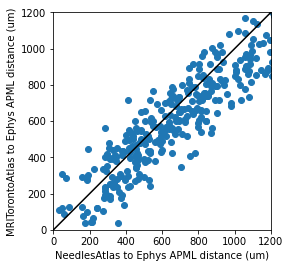

In [102]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(na_dists,mri_dists,'o')
plt.plot([0,1200],[0,1200],'-k')
plt.xlim([0, 1200])
plt.ylim([0, 1200])
plt.xlabel('NeedlesAtlas to Ephys APML distance (um)')
plt.ylabel('MRITorontoAtlas to Ephys APML distance (um)')
ax.set_aspect('equal', adjustable='box')

In [103]:
np.median(na_dists)

708.7081432670293

In [104]:
np.median(mri_dists)

658.3281371747667

Text(0.5, 0, 'NeedlesAtlas to ephys distance minus MRITorontoAtlas to ephys distance (um)')

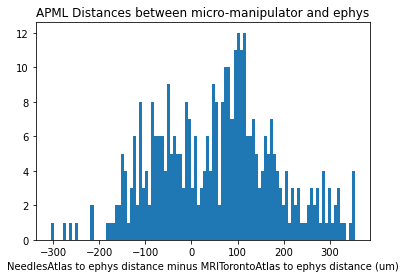

In [105]:
plt.hist(np.subtract(na_dists,mri_dists),bins=100)
plt.title('APML Distances between micro-manipulator and ephys')
plt.xlabel('NeedlesAtlas to ephys distance minus MRITorontoAtlas to ephys distance (um)')

# Compute the transform using micro-manipulator coordinates

In [106]:
raw_data = pd.read_csv('bwm_raw_coords.csv')

In [107]:
raw_data

,Unnamed: 0,pid,x_micro,y_micro,z_micro,x_ephys,y_ephys,z_ephys
0,0,47be9ae4-290f-46ab-b047-952bc3a1a509,-1829.0,-1250.0,0.0,-2440.883,-790.500,-393.0
1,1,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,-2704.0,-2000.0,0.0,-2663.621,-1594.194,-293.0
2,2,1e176f17-d00f-49bb-87ff-26d237b525f1,-2243.0,-2000.0,-169.0,-2477.615,-1751.430,-218.0
3,3,701026df-e170-4ca7-88aa-eb0b95ef6ba1,-2338.0,-3250.0,0.0,-2748.396,-3017.230,-268.0
4,4,6506252f-1141-4e11-8816-4db01b71dda0,-2345.9,-1750.0,-217.0,-2982.166,-1663.689,-443.0
...,...,...,...,...,...,...,...,...
362,362,81b1800e-f138-4337-abc9-bb0449b77852,-810.3,-2994.6,-402.7,-714.000,-2875.000,157.0
363,363,5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e,-806.0,-5180.3,-822.2,-839.000,-4775.000,-943.0
364,364,f7c93877-ec05-4091-a003-e69fae0f2fa8,-3128.0,-1094.1,-850.3,-3139.000,-1275.000,-593.0
365,365,675952a4-e8b3-4e82-a179-cc970d5a8b01,-1833.8,-251.5,-408.4,-2664.000,-650.000,-518.0


In [108]:
def compute_transform(row):
    # use only ap/ml for now
    bregma_dist = np.sqrt(row['x_ephys']**2+row['y_ephys']**2)
    x_scale = row['x_micro']/row['x_ephys']
    y_scale = row['y_micro']/row['y_ephys']
    # z_scale = row['z_micro']/row['z_ephys']
    z_scale = 0
    return (x_scale, y_scale, z_scale, bregma_dist)

In [109]:
x_scale = []
y_scale = []
z_scale = []
bregma = []
for i, row in raw_data.iterrows():
    try:
        (x,y,z,b) = compute_transform(row)
        x_scale.append(x)
        y_scale.append(y)
        z_scale.append(z)
        bregma.append(b)
    except:
        pass

In [110]:
print((np.median(x_scale), np.median(y_scale)))

(0.9507346585998271, 0.989010989010989)


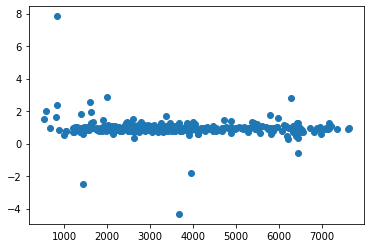

In [111]:
plt.plot(bregma,x_scale,'o')

# Individual mouse probe-matching analysis
Check whether in one mouse we think that the micro-manipulator coordinates are properly matched with the ephys coordinates

In [112]:
umice = np.unique(ins['subject'])

In [135]:
r = lambda: random.randint(0,255)
randHexColor = lambda : '#%02X%02X%02X' % (r(),r(),r())

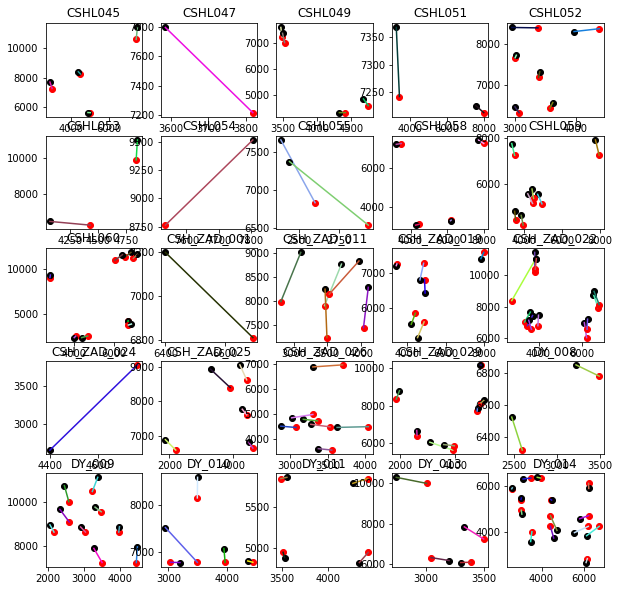

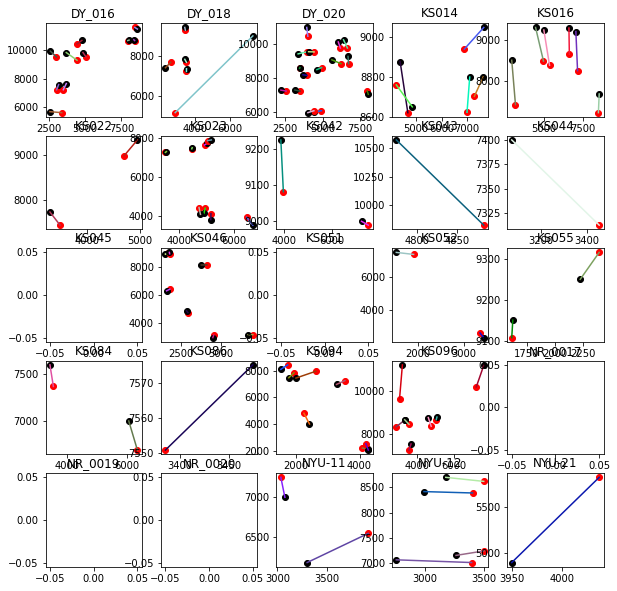

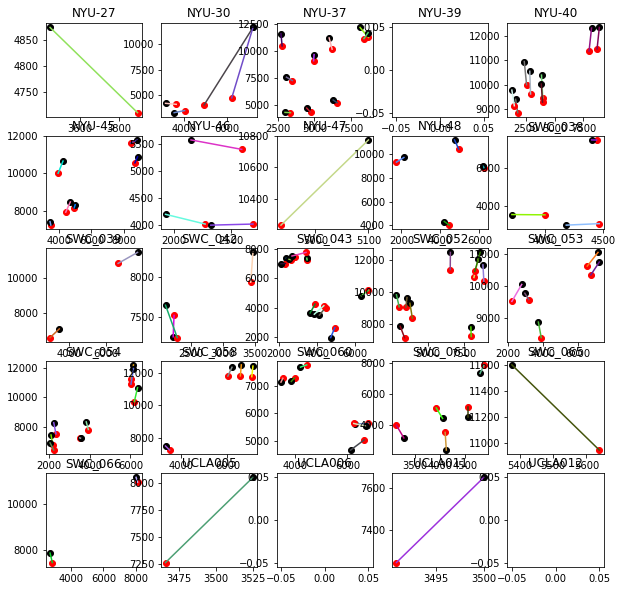

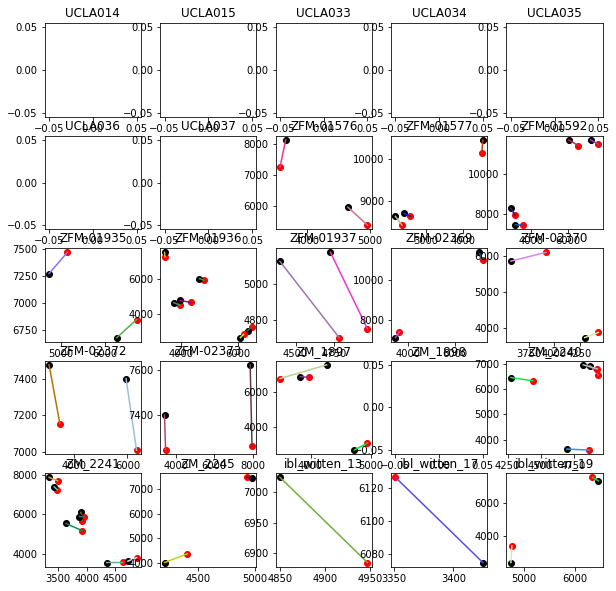

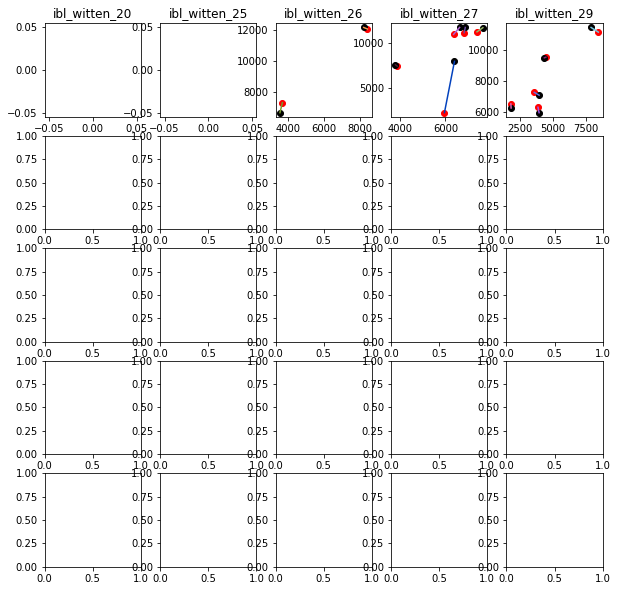

In [160]:
for i, mouse in enumerate(umice):
    idx = np.mod(i,25)
    if idx==0:
        fig, axs = plt.subplots(5, 5, figsize=(10,10))
        axs = axs.flatten()
    
    # get all the insertions for this mouse
    pids = ins[ins['subject']==mouse]['pid']
    # get the entry coordinates for micro-manip and ephys for this mouse

    # plt.title(mouse)
    for pid in pids.values:
        mdata = traj_data[traj_data['pid']==pid]
        color = randHexColor()
        axs[idx].plot(mdata['ml_e_m'],mdata['ap_e_m'],'o',color='#ff0000')
        axs[idx].plot(mdata['ml_e_e'],mdata['ap_e_e'],'o',color='#000000')
        coordx = [mdata['ml_e_m'],mdata['ml_e_e']]
        coordy = [mdata['ap_e_m'],mdata['ap_e_e']]
        axs[idx].plot(coordx,coordy,'-',color=color)
    axs[idx].title.set_text(mouse)
    # axs[i].axis('equal')
# plt.xlim([0,11400])
# plt.ylim([0,13200])
# plt.axis('equal')

# Display data using Urchin

In [11]:
import random
r = lambda: random.randint(0,255)
randHexColor = lambda : '#%02X%02X%02X' % (r(),r(),r())

In [22]:
colors = {}
labs = np.unique(traj_data['lab'].values)

for lab in labs:
    colors[lab] = randHexColor()

In [9]:
urn.setup()

(URN) connected to server
Login sent with ID: Dan


In [ ]:
# VIEW 1: Planned insertions
urn.clear()
count = 0

for i, row in traj_data.iterrows():
    probename = 'p'+str(i)
    urn.create_probes([probename])
    urn.set_probe_positions({probename:[row.ml, row.ap, row.dv]})
    urn.set_probe_colors({probename:'#808080'})
    urn.set_probe_angles({probename:[row.phi, row.theta, 0]})
    urn.set_probe_size({probename:[0.07,3.84,0.02]})

# # for some reason 'root' doesn't work?
urn.set_area_visibility({8:True})
urn.set_area_material({8:'transparent-unlit'})
urn.set_area_color({8:'#000000'})
urn.set_area_alpha({8:0.025})

In [56]:
urn.clear()

In [224]:
np.unique(traj_data['lab'].values)

array(['angelakilab', 'churchlandlab', 'churchlandlab_ucla', 'cortexlab',
       'danlab', 'hoferlab', 'mainenlab', 'mrsicflogellab', 'wittenlab',
       'zadorlab'], dtype=object)

# Trace matching